In [630]:
#import des librairies/packages nécessaires
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from  sklearn import preprocessing,impute,model_selection,dummy,metrics,linear_model,tree,decomposition,ensemble
from lightgbm import LGBMClassifier
from sklearn.experimental import enable_iterative_imputer
import numpy as np
import time

# Exploration

Chargement du fichier principal

In [794]:
df_app_tot = pd.read_csv('Data/application_train.csv')
df_app_tot.shape

(307511, 122)

In [795]:
df_app.head(10)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOMALIE
0,100002,1,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0,0,1,1,0,False
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,0,1,0,0,0,0,0,1,0,False
2,100004,0,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,0,1,0,0,0,0,0,0,0,False
3,100006,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0,0,1,0,0,False
4,100007,0,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,1,0,0,0,0,False
5,100008,0,0,0,1,0,99000.0,490495.5,27517.5,454500.0,...,0,0,0,0,0,0,1,0,0,False
6,100009,0,0,1,1,1,171000.0,1560726.0,41301.0,1395000.0,...,0,0,0,1,0,0,0,0,0,False
7,100010,0,0,1,1,0,360000.0,1530000.0,42075.0,1530000.0,...,0,1,0,0,0,0,0,0,0,False
8,100011,0,0,0,1,0,112500.0,1019610.0,33826.5,913500.0,...,0,0,0,0,0,0,1,0,0,True
9,100012,0,1,0,1,0,135000.0,405000.0,20250.0,405000.0,...,0,0,0,0,1,0,0,0,0,False


Recherche de doublons

In [796]:
df_app_tot.duplicated(subset='SK_ID_CURR').sum()

0

La répartition des individus ci-dessous montre un déséquilibre des classes dont il faudra tenir compte

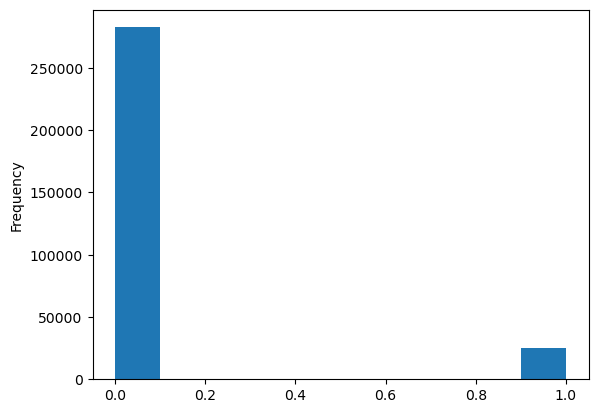

In [797]:
df_app_tot['TARGET'].plot.hist();

- ## Nettoyage

In [798]:
# Calcul du pourcentage de valeurs manquantes par variable
(df_app_tot.isna().sum()/len(df_app_tot)).nlargest(50)

COMMONAREA_AVG                  0.698723
COMMONAREA_MODE                 0.698723
COMMONAREA_MEDI                 0.698723
NONLIVINGAPARTMENTS_AVG         0.694330
NONLIVINGAPARTMENTS_MODE        0.694330
NONLIVINGAPARTMENTS_MEDI        0.694330
FONDKAPREMONT_MODE              0.683862
LIVINGAPARTMENTS_AVG            0.683550
LIVINGAPARTMENTS_MODE           0.683550
LIVINGAPARTMENTS_MEDI           0.683550
FLOORSMIN_AVG                   0.678486
FLOORSMIN_MODE                  0.678486
FLOORSMIN_MEDI                  0.678486
YEARS_BUILD_AVG                 0.664978
YEARS_BUILD_MODE                0.664978
YEARS_BUILD_MEDI                0.664978
OWN_CAR_AGE                     0.659908
LANDAREA_AVG                    0.593767
LANDAREA_MODE                   0.593767
LANDAREA_MEDI                   0.593767
BASEMENTAREA_AVG                0.585160
BASEMENTAREA_MODE               0.585160
BASEMENTAREA_MEDI               0.585160
EXT_SOURCE_1                    0.563811
NONLIVINGAREA_AV

On supprime les colonnes avec plus de 60% de valeurs manquantes

In [799]:
col_empty=df_app_tot.columns[(df_app_tot.isna().sum()/len(df_app_tot))>0.6]

In [801]:
df_app=df_app_tot.drop(columns=col_empty)

In [802]:
df_app.dtypes.value_counts()

float64    49
int64      41
object     15
dtype: int64

In [803]:
df_app.select_dtypes('object').apply(pd.Series.nunique)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [804]:
# Suppression des variables catégorielles comprenant trop de modalités
col_to_drop=df_app.select_dtypes('object').columns[(df_app.select_dtypes('object').apply(pd.Series.nunique)>10)]
df_app=df_app.drop(columns=col_to_drop)

- ## Encodage

In [805]:
le = preprocessing.LabelEncoder()
i = 0

print('LABEL ENCODING WITH sklearn')
for col in df_app.columns :
    if df_app[col].dtypes == 'object' :
        i+=1
        if len(df_app[col].unique()) <= 2 :
            enc_col=le.fit_transform(df_app[col]).reshape(-1,1)
            df_app[col]=enc_col
            
print('ONE HOT ENCODING WITH get_dummies')
print('--------------------------------------')
df_app = pd.get_dummies(df_app)

print('Taille du dataframe encodé',df_app.shape)

LABEL ENCODING WITH sklearn
ONE HOT ENCODING WITH get_dummies
--------------------------------------
Taille du dataframe encodé (307511, 147)


Détection des anomalies de certaines variables

In [806]:
# L'âge des clients est donné en jours et compté négativement. On prend la valeur absolue pour être plus pertinent
df_app['DAYS_BIRTH']=abs(df_app['DAYS_BIRTH'])

In [807]:
# Description de la variable en année
(df_app['DAYS_BIRTH']/365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

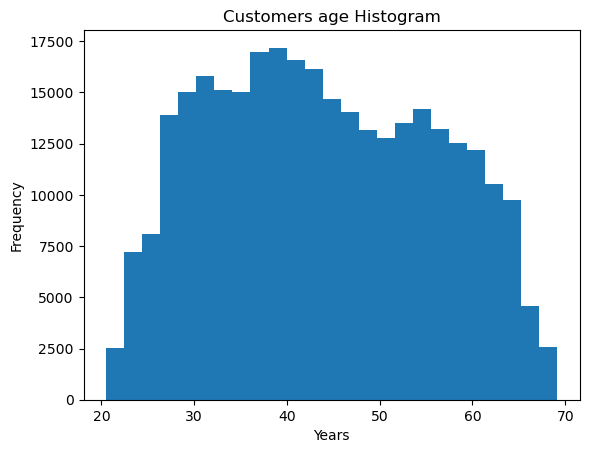

In [808]:
(df_app['DAYS_BIRTH']/365).plot.hist(title = 'Customers age Histogram',bins=25);
plt.xlabel('Years');

In [809]:
#Expérience professionnelle. On procède au même traitement 
df_app['DAYS_EMPLOYED']=abs(df_app['DAYS_EMPLOYED'])

In [810]:
(df_app['DAYS_EMPLOYED']/365).describe()

count    307511.000000
mean        185.547239
std         382.037676
min           0.000000
25%           2.556164
50%           6.079452
75%          15.635616
max        1000.665753
Name: DAYS_EMPLOYED, dtype: float64

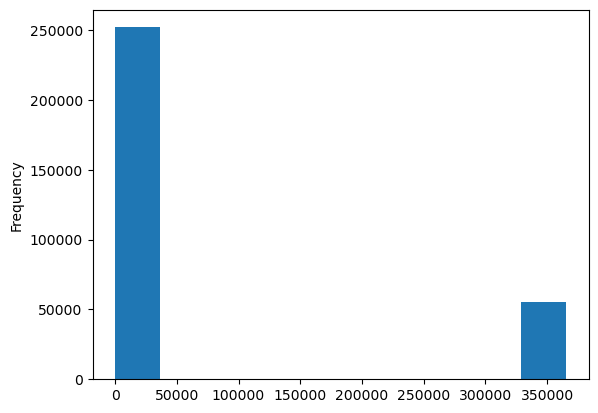

In [811]:
df_app['DAYS_EMPLOYED'].plot.hist();

In [812]:
n_outlier = (df_app['DAYS_EMPLOYED']==df_app['DAYS_EMPLOYED'].max()).sum()
print(n_outlier, 'individus possèdent cette anomalie')

55374 individus possèdent cette anomalie


In [813]:
def_anom=df_app[df_app['DAYS_EMPLOYED']==df_app['DAYS_EMPLOYED'].max()]['TARGET'].mean()*100
def_non_anom=df_app[df_app['DAYS_EMPLOYED']!=df_app['DAYS_EMPLOYED'].max()]['TARGET'].mean()*100
print(round(def_anom,2),'% des individus avec cette anomalie ne remboursent pas leur emprunt')
print(round(def_non_anom,2),'% des individus sans cette anomalie ne remboursent pas leur emprunt')

5.4 % des individus avec cette anomalie ne remboursent pas leur emprunt
8.66 % des individus sans cette anomalie ne remboursent pas leur emprunt


L'anomalie semble avoir une corrélation avec le taux de défaut de remboursement

In [814]:
#On identifie les anomalies
df_app['DAYS_EMPLOYED_ANOMALIE'] = df_app["DAYS_EMPLOYED"] == df_app['DAYS_EMPLOYED'].max()

#Remplacement des anomalies par NaN
df_app['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)


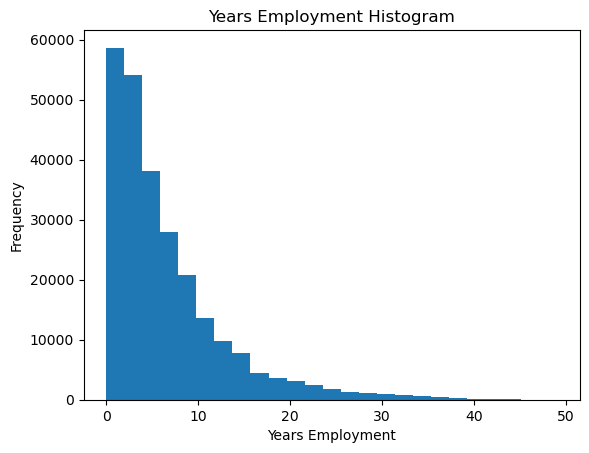

In [815]:
# Visualisation de la distribution de la variable
(df_app['DAYS_EMPLOYED']/365).plot.hist(title = 'Years Employment Histogram', bins=25);
plt.xlabel('Years Employment');

- ## Corrélations

In [816]:
#Correlation avec la TARGET
corr = df_app.corr()['TARGET']

In [817]:
#Les 10 variables les plus positivement corrélées avec TARGET
corr.nlargest(10)

TARGET                                               1.000000
REGION_RATING_CLIENT_W_CITY                          0.060893
REGION_RATING_CLIENT                                 0.058899
NAME_INCOME_TYPE_Working                             0.057481
DAYS_LAST_PHONE_CHANGE                               0.055218
CODE_GENDER_M                                        0.054713
DAYS_ID_PUBLISH                                      0.051457
REG_CITY_NOT_WORK_CITY                               0.050994
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
FLAG_EMP_PHONE                                       0.045982
Name: TARGET, dtype: float64

In [818]:
#Les 10 variables les plus négativement corrélées avec TARGET
corr.nsmallest(10)

EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
DAYS_BIRTH                             -0.078239
DAYS_EMPLOYED                          -0.074958
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
NAME_INCOME_TYPE_Pensioner             -0.046209
DAYS_EMPLOYED_ANOMALIE                 -0.045987
FLOORSMAX_AVG                          -0.044003
Name: TARGET, dtype: float64

In [936]:
corr

SK_ID_CURR                        -0.002108
TARGET                             1.000000
NAME_CONTRACT_TYPE                -0.030896
FLAG_OWN_CAR                      -0.021851
FLAG_OWN_REALTY                   -0.006148
                                     ...   
WALLSMATERIAL_MODE_Stone, brick   -0.012657
WALLSMATERIAL_MODE_Wooden          0.007946
EMERGENCYSTATE_MODE_No            -0.042201
EMERGENCYSTATE_MODE_Yes            0.004829
DAYS_EMPLOYED_ANOMALIE            -0.045987
Name: TARGET, Length: 148, dtype: float64

In [947]:
col_to_keep=corr[(corr>0.03)|(corr<-0.03)].index

Les plus grosses corrélations (hors EXT_SOURCE) sont `DAYS_BIRTH` et `DAYS_EMPLOYED`. Elles sont corrélées négativement, donc plus l'âge/le temps d'emploi augmente, plus `TARGET` se rapproche de 0 (donc le client rembourse le crédit)

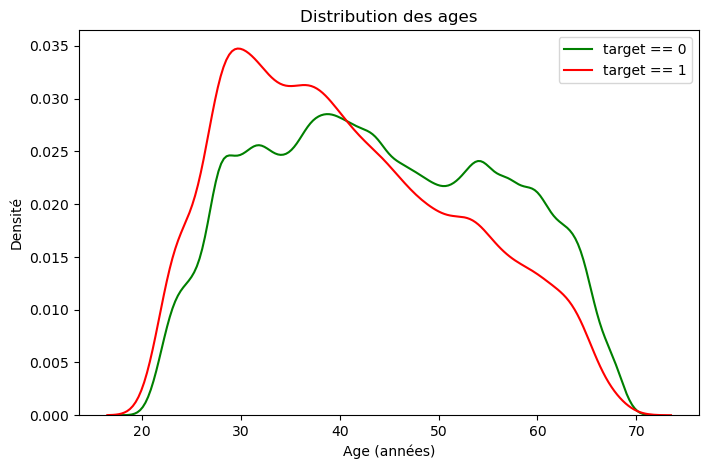

In [819]:
# Les histogrammes de ces variables ne nous donnent pas beaucoup d'informations. On visualise la densité selon la valeur de `TARGET`

plt.figure(figsize = (8, 5))

sns.kdeplot(df_app.loc[df_app['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0', color = 'green')
sns.kdeplot(df_app.loc[df_app['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1', color = 'red')
plt.legend()
plt.xlabel('Age (années)'); plt.ylabel('Densité'); plt.title('Distribution des ages');

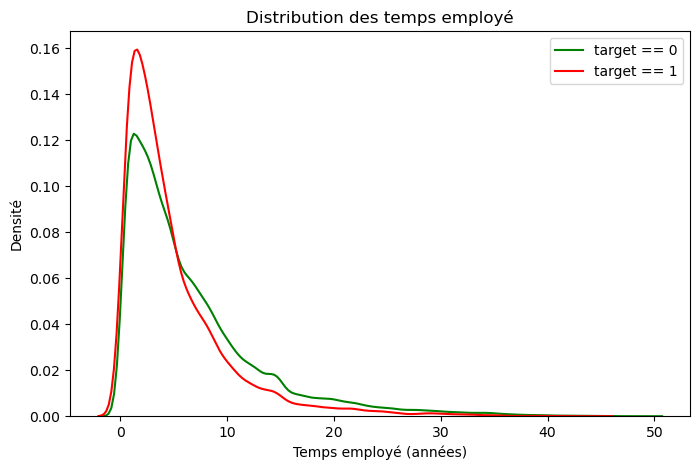

In [820]:
plt.figure(figsize = (8, 5))

sns.kdeplot(df_app.loc[df_app['TARGET'] == 0, 'DAYS_EMPLOYED'] / 365, label = 'target == 0', color = 'green')
sns.kdeplot(df_app.loc[df_app['TARGET'] == 1, 'DAYS_EMPLOYED'] / 365, label = 'target == 1', color = 'red')
plt.legend()
plt.xlabel('Temps employé (années)'); plt.ylabel('Densité'); plt.title('Distribution des temps employé');

Les clients plus agés semblent rembourser leurs prêts plus souvent. On peut remarquer cette même tendance avec le nombre d'années employé.
On étudie le taux de remboursement par tranche d'âge

In [821]:
#Création des variables 'années'
df_days = df_app[['TARGET','DAYS_BIRTH','DAYS_EMPLOYED']]
df_days.loc[:,'YEARS_BIRTH']=df_days['DAYS_BIRTH']/365
df_days.loc[:,'YEARS_EMPLOYED']=df_days['DAYS_EMPLOYED']/365

C:\Users\BENAVEN\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\BENAVEN\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [822]:
df_days.loc[:,'AGE_GROUP']=pd.cut(df_days['YEARS_BIRTH'],np.linspace(20,70,11))
df_days.loc[:,'EMPLOYED_GROUP']=pd.cut(df_days['YEARS_EMPLOYED'],np.linspace(0,50,11))

C:\Users\BENAVEN\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\BENAVEN\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\BENAVEN\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [823]:
age_group=df_days.groupby(by='AGE_GROUP').mean()
age_group

,TARGET,DAYS_BIRTH,DAYS_EMPLOYED,YEARS_BIRTH,YEARS_EMPLOYED
AGE_GROUP,,,,,
"(20.0, 25.0]",0.123036,8532.795625,782.039340,23.377522,2.142574
"(25.0, 30.0]",0.111436,10155.219250,1296.129915,27.822518,3.551041
"(30.0, 35.0]",0.102814,11854.848377,1782.401976,32.479037,4.883293
"(35.0, 40.0]",0.089414,13707.908253,2228.224339,37.555913,6.104724
"(40.0, 45.0]",0.078491,15497.661233,2614.013344,42.459346,7.161680
"(45.0, 50.0]",0.074171,17323.900441,2902.413697,47.462741,7.951818
"(50.0, 55.0]",0.066968,19196.494791,3309.225229,52.593136,9.066370
"(55.0, 60.0]",0.055314,20984.262742,3721.095985,57.491131,10.194784
"(60.0, 65.0]",0.052737,22780.547460,4209.830820,62.412459,11.533783


In [824]:
emp_group=df_days.groupby(by='EMPLOYED_GROUP').mean()
emp_group

,TARGET,DAYS_BIRTH,DAYS_EMPLOYED,YEARS_BIRTH,YEARS_EMPLOYED
EMPLOYED_GROUP,,,,,
"(0.0, 5.0]",0.105708,13891.940173,864.340763,38.060110,2.368057
"(5.0, 10.0]",0.073714,14975.263334,2630.224689,41.028119,7.206095
"(10.0, 15.0]",0.057752,16063.002142,4466.899670,44.008225,12.238081
"(15.0, 20.0]",0.048484,16874.667619,6306.860448,46.231966,17.279070
"(20.0, 25.0]",0.047573,17548.852475,8092.875701,48.079048,22.172262
"(25.0, 30.0]",0.039903,18690.112152,9961.437122,51.205787,27.291609
"(30.0, 35.0]",0.041258,19956.497163,11791.751418,54.675335,32.306168
"(35.0, 40.0]",0.019231,21286.932692,13517.634615,58.320364,37.034615
"(40.0, 45.0]",0.004762,22783.171429,15325.461905,62.419648,41.987567


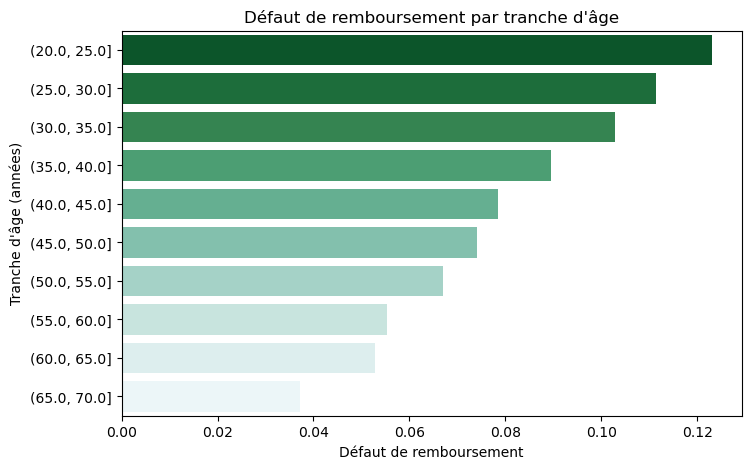

In [825]:
data=age_group
data=data.reset_index()
plt.figure(figsize = (8, 5))
sns.barplot(data=data,y='AGE_GROUP',x='TARGET', palette='BuGn_r');
plt.xlabel('Défaut de remboursement')
plt.ylabel("Tranche d'âge (années)")
plt.title("Défaut de remboursement par tranche d'âge");

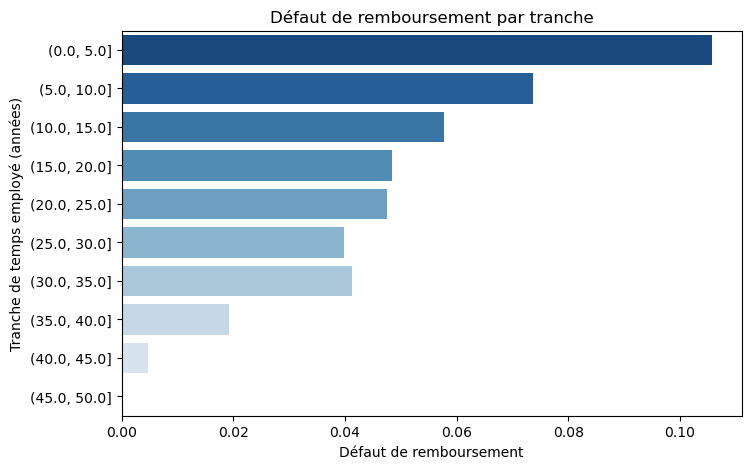

In [826]:
data=emp_group
data=data.reset_index()
plt.figure(figsize = (8, 5))
sns.barplot(data=data,y='EMPLOYED_GROUP',x='TARGET',palette='Blues_r');
plt.xlabel('Défaut de remboursement')
plt.ylabel("Tranche de temps employé (années)")
plt.title("Défaut de remboursement par tranche");

L'âge et le temps d'emploi influent directement sur la capacité à rembourser

### Etude des EXT_SOURCES
Les variables `EXT_SOURCES` sont bien corrélées avec `TARGET`. Etudions les corérlations plus en détails

In [827]:
df_ext=df_app[['TARGET','DAYS_BIRTH','EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']]
corr_ext=df_ext.corr()

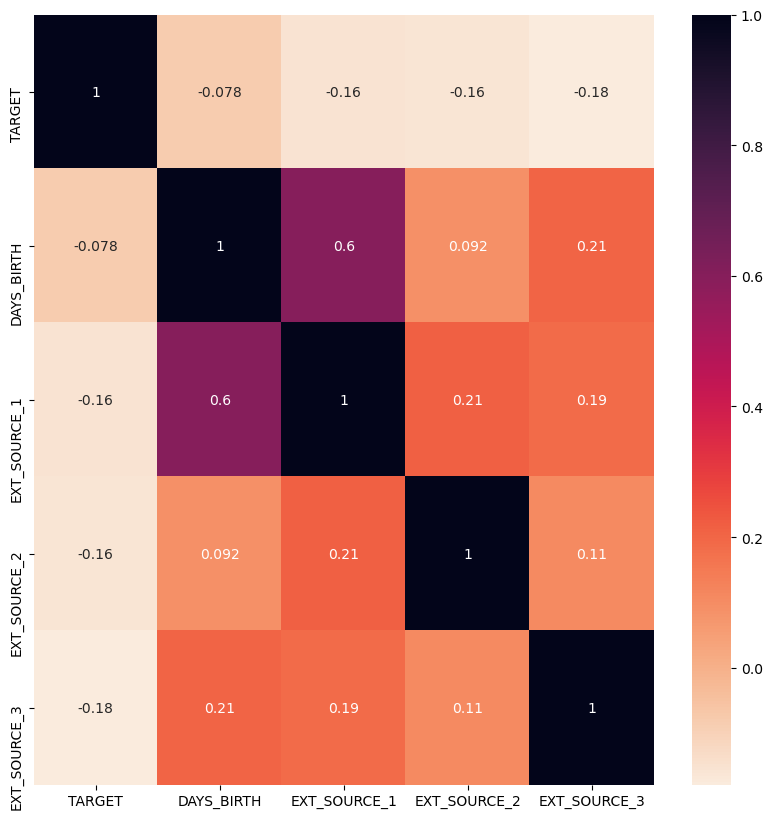

In [828]:
plt.figure(figsize=(10,10))
sns.heatmap(corr_ext, annot=True, cmap = 'rocket_r');

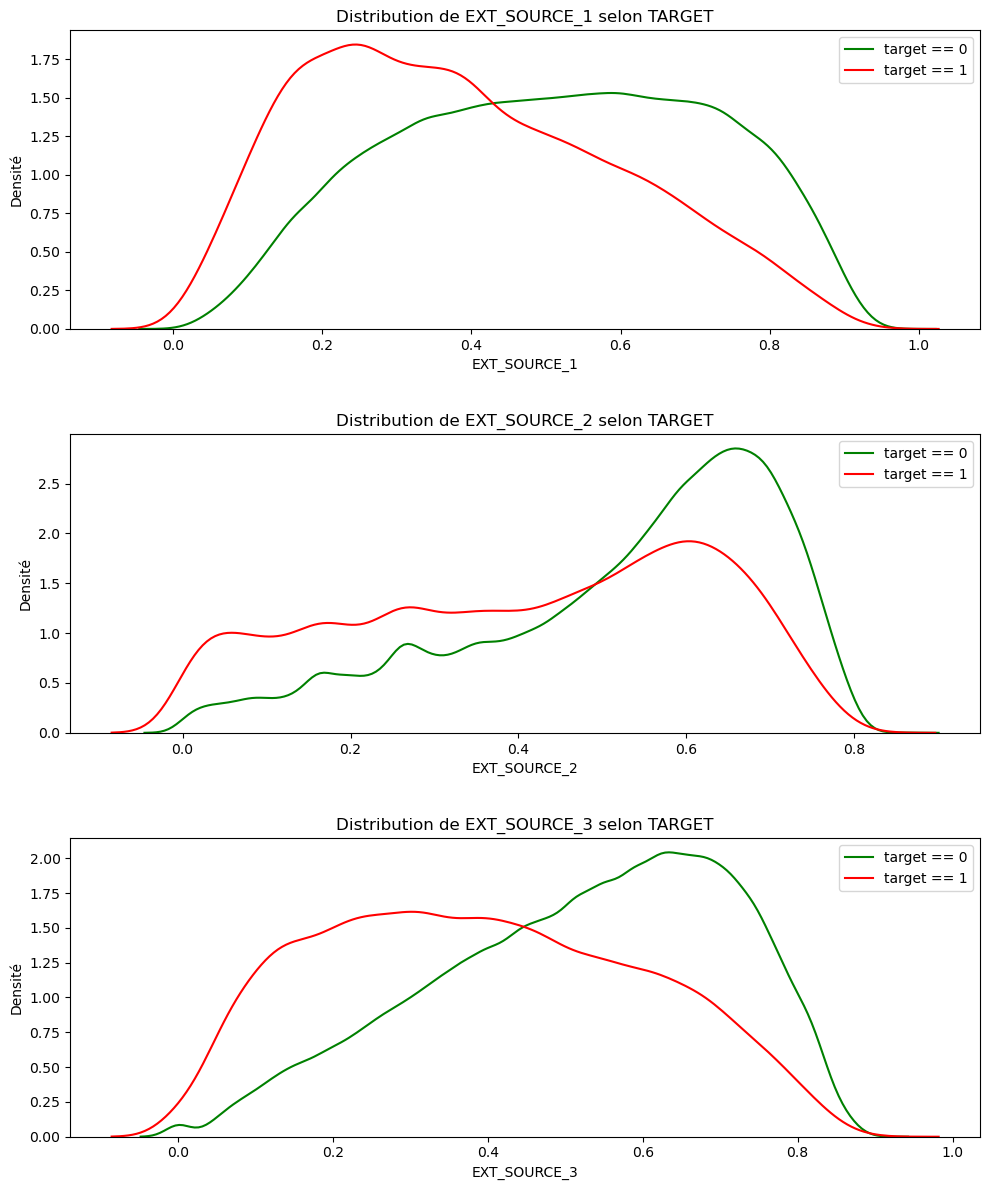

In [829]:
plt.figure(figsize = (10, 12))

for i, ext in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
  
    plt.subplot(3, 1, i + 1)
    sns.kdeplot(df_app.loc[df_app['TARGET'] == 0, ext], label = 'target == 0',color='green')
    sns.kdeplot(df_app.loc[df_app['TARGET'] == 1, ext], label = 'target == 1',color='red')
    
    plt.legend()
    plt.title('Distribution de %s selon TARGET' % ext)
    plt.xlabel('%s' % ext); plt.ylabel('Densité');
    
plt.tight_layout(h_pad = 3)
    

La variable `EXT_SOURCE_3` est celle dont la distribution est la plus différente selon la TARGET.

In [830]:
df_ext['YEARS_BIRTH']=df_days['YEARS_BIRTH']

<ipython-input-830-e483c852f35a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ext['YEARS_BIRTH']=df_days['YEARS_BIRTH']


C:\Users\BENAVEN\anaconda3\lib\site-packages\seaborn\distributions.py:1181: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(
C:\Users\BENAVEN\anaconda3\lib\site-packages\seaborn\distributions.py:1181: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(
C:\Users\BENAVEN\anaconda3\lib\site-packages\seaborn\distributions.py:1181: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(
C:\Users\BENAVEN\anaconda3\lib\site-packages\seaborn\distributions.py:1181: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(
C:\Users\BENAVEN\anaconda3\lib\site-packages\seaborn\distributions.py:1181: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(
C:\Users\BENAVEN\anaconda3\lib\site-packages\seaborn\distributions.py:1181: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(
C:\Users\BENAVEN\anaco

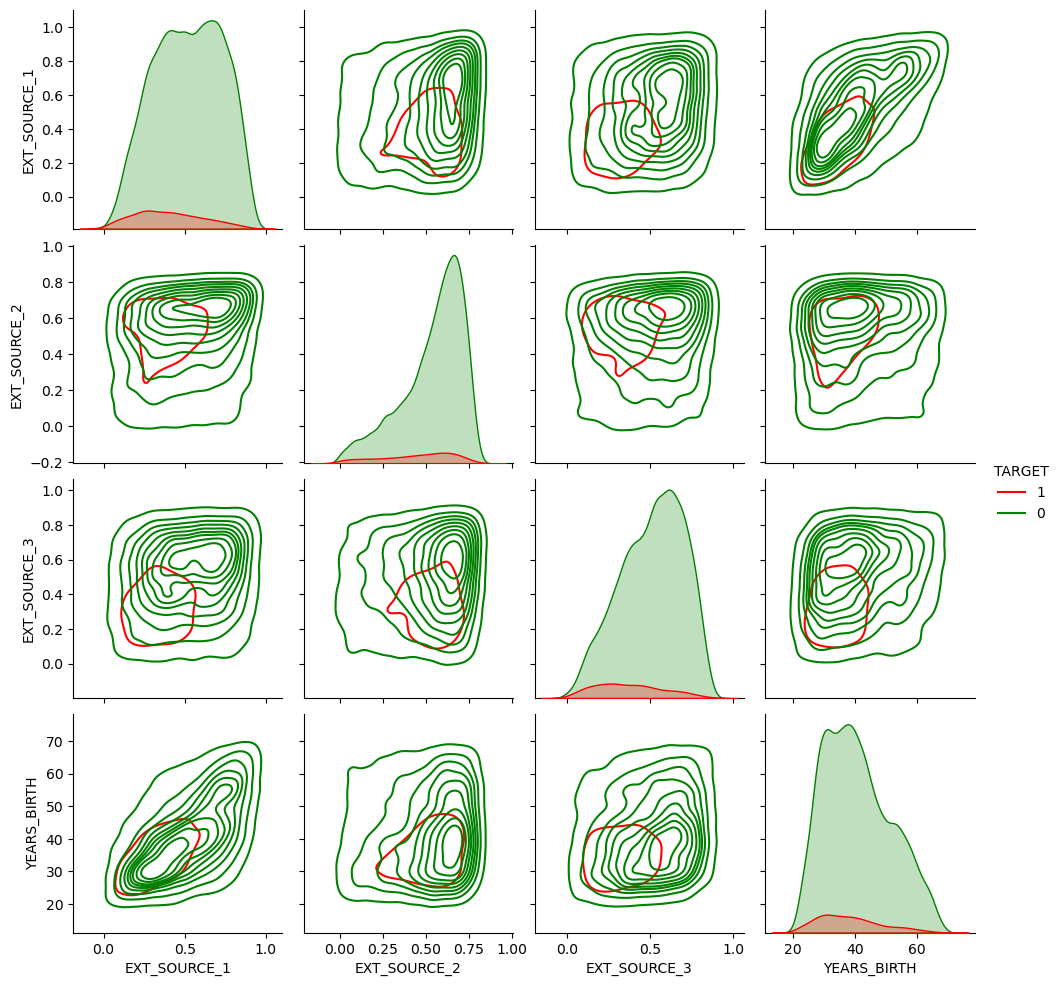

In [831]:
data=df_ext.dropna().sample(frac=0.1)
sns.pairplot(data=data,hue='TARGET',hue_order=[1,0],palette=['red','green'] ,vars=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3','YEARS_BIRTH'], kind='kde');

La corrélation entre `EXT_SOURCE_1` et `YEARS_BIRTH` peut se vérifier sur cette visualisation

# Feature Engineering
- ### Polynomial features
Dans un premier temps, on impute les valeurs manquantes des variables EXT

In [832]:
# On teste les méthodes d'imputation par la médiane et une méthode itérative
df_poly = df_app[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','DAYS_BIRTH']]
iter_imp=impute.IterativeImputer(random_state=0,min_value=0, max_value=1)
med_imp=impute.SimpleImputer(missing_values=np.nan,strategy='median')
df_poly_iter=iter_imp.fit_transform(df_poly)
df_poly_med=med_imp.fit_transform(df_poly)

In [833]:
df_poly.describe()

,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
count,134133.000000,3.068510e+05,246546.000000,307511.000000
mean,0.502130,5.143927e-01,0.510853,16036.995067
std,0.211062,1.910602e-01,0.194844,4363.988632
min,0.014568,8.173617e-08,0.000527,7489.000000
25%,0.334007,3.924574e-01,0.370650,12413.000000
50%,0.505998,5.659614e-01,0.535276,15750.000000
75%,0.675053,6.636171e-01,0.669057,19682.000000
max,0.962693,8.549997e-01,0.896010,25229.000000


In [834]:
pd.DataFrame(df_poly_iter).describe()

,0,1,2,3
count,307511.000000,3.075110e+05,307511.000000,307511.000000
mean,0.541996,5.144037e-01,0.509518,16036.995067
std,0.179937,1.908596e-01,0.175768,4363.988632
min,0.014568,8.173617e-08,0.000527,7489.000000
25%,0.411508,3.929737e-01,0.411849,12413.000000
50%,0.557162,5.655316e-01,0.520848,15750.000000
75%,0.685900,6.634218e-01,0.636376,19682.000000
max,0.962693,8.549997e-01,0.896010,25229.000000


Création des polynomes

In [836]:
poly=preprocessing.PolynomialFeatures(degree=3)
df_poly_feat=poly.fit_transform(df_poly_iter)

In [837]:
poly.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2',
 'EXT_SOURCE_1^3',
 'EXT_SOURCE_1^2 EXT_SOURCE_2',
 'EXT_SOURCE_1^2 EXT_SOURCE_3',
 'EXT_SOURCE_1^2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_2^2',
 'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_3^2',
 'EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_1 DAYS_BIRTH^2',
 'EXT_SOURCE_2^3',
 'EXT_SOURCE_2^2 EXT_SOURCE_3',
 'EXT_SOURCE_2^2 DAYS_BIRTH',
 'EXT_SOURCE_2 EXT_SOURCE_3^2',
 'EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_2 DAYS_BIRTH^2',
 'EXT_SOURCE_3^3',
 'EXT_SOURCE_3^2 DAYS_BIRTH',
 'EXT_SOURCE_3 DAYS_BIRTH^2',
 'DAYS_BIRTH^3']

In [838]:
# Création d'un dataframe pour manipuler plus facilement
df_poly_feat=pd.DataFrame(df_poly_feat,columns=poly.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))
df_poly_feat['TARGET']=df_app['TARGET']

Calcul des corrélation de ces polynomes avec la variable `TARGET`

In [839]:
poly_corr = df_poly_feat.corr()['TARGET']

In [840]:
#Les 10 polynomes les plus positivement corrélées avec TARGET
poly_corr.nlargest(5)

TARGET                       1.000000
DAYS_BIRTH^3                -0.074273
DAYS_BIRTH^2                -0.076672
DAYS_BIRTH                  -0.078239
EXT_SOURCE_1 DAYS_BIRTH^2   -0.098315
Name: TARGET, dtype: float64

In [1605]:
#Les 10 polynomes les plus négativement corrélées avec TARGET
poly_corr.nsmallest(10)

EXT_SOURCE_2 EXT_SOURCE_3                -0.195460
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.187661
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.180693
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.177153
EXT_SOURCE_1 EXT_SOURCE_3                -0.176023
EXT_SOURCE_1 EXT_SOURCE_2                -0.174721
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.174065
EXT_SOURCE_3                             -0.164677
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.161446
EXT_SOURCE_2                             -0.160341
Name: TARGET, dtype: float64

Aucune variable n'est positivement corrélée (nos variables initiales ne l'étaient pas). Cependant certaines nouvelles variables sont davantage négativement corrélées

On crée un nouveau dataframe pour inclure ces variables et tester plus tard si elles ont un impact sur les performances du modèle

In [1598]:
#Jointure des polynomes avec le dataframe principal
df_poly_feat['SK_ID_CURR']=df_app['SK_ID_CURR']
df_app_poly=df_app.merge(df_poly_feat, on='SK_ID_CURR', how='left')

In [1600]:
#Suppression des colonnes doublées et renommage
df_app_poly=df_app_poly.drop(columns=['TARGET_y','DAYS_BIRTH_y','EXT_SOURCE_1_y','EXT_SOURCE_2_y','EXT_SOURCE_3_y'])
df_app_poly=df_app_poly.rename(columns={'TARGET_x':'TARGET','DAYS_BIRTH_x':'DAYS_BIRTH','EXT_SOURCE_1_x':'EXT_SOURCE_1','EXT_SOURCE_2_x':'EXT_SOURCE_2','EXT_SOURCE_3_x':'EXT_SOURCE_3'})

## Création variables métiers

In [845]:
# Création de variables métiers supplémentaires
df_app_domain=df_app.copy()

df_app_domain['DAYS_EMPLOYED_PERC']=df_app_domain['DAYS_EMPLOYED']/df_app_domain['DAYS_BIRTH']
df_app_domain['INCOME_CREDIT_PERC']=df_app_domain['AMT_INCOME_TOTAL']/df_app_domain['AMT_CREDIT']
df_app_domain['ANNUITY_INCOME_PERC']=df_app_domain['AMT_ANNUITY']/df_app_domain['AMT_INCOME_TOTAL']
df_app_domain['PAYMENT_RATE']=df_app_domain['AMT_ANNUITY']/df_app_domain['AMT_CREDIT']

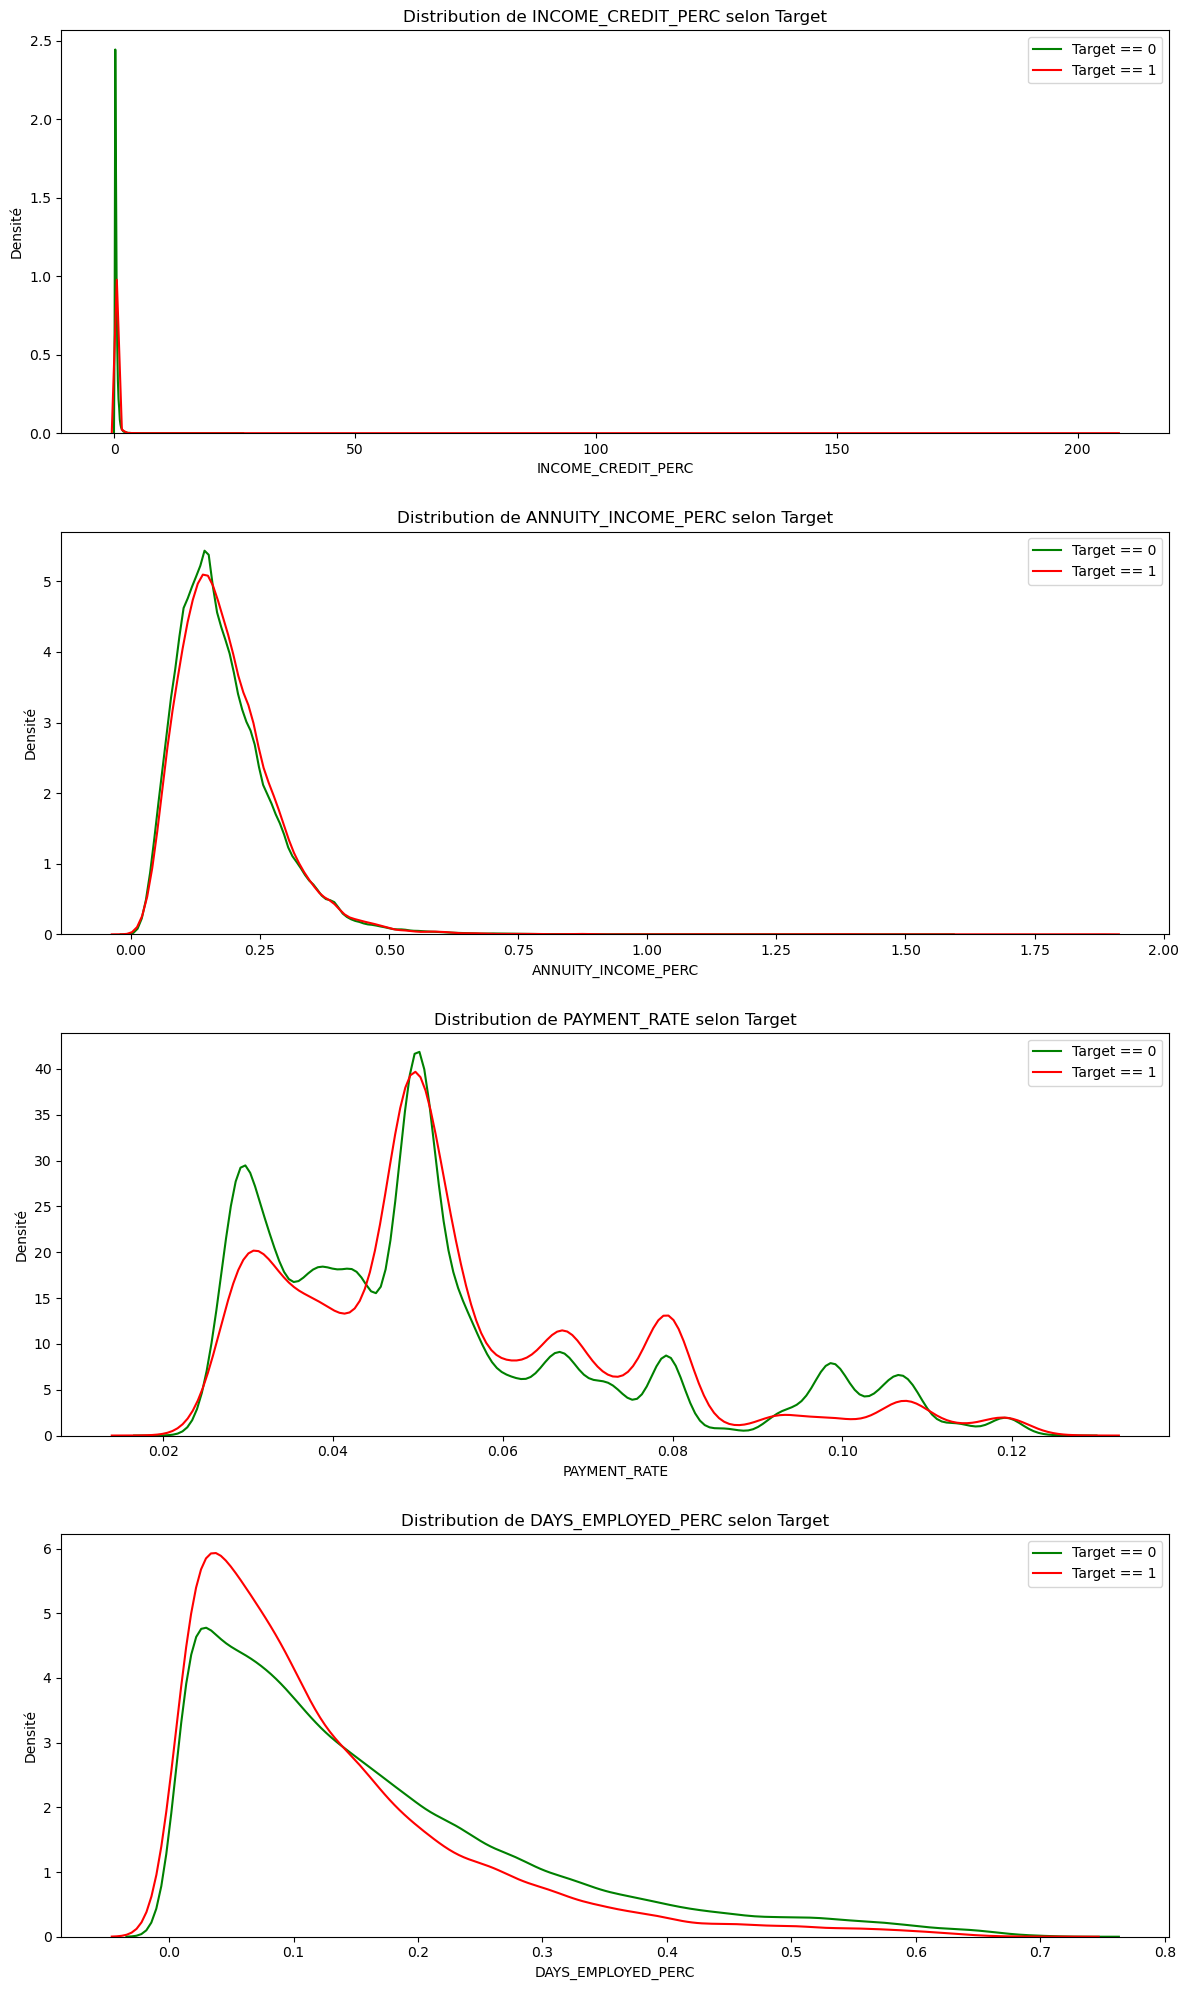

In [846]:
plt.figure(figsize = (12, 20))
for i, feature in enumerate(['INCOME_CREDIT_PERC', 'ANNUITY_INCOME_PERC', 'PAYMENT_RATE', 'DAYS_EMPLOYED_PERC']):
    
    plt.subplot(4, 1, i + 1)
    sns.kdeplot(df_app_domain.loc[df_app_domain['TARGET'] == 0, feature], label = 'Target == 0', color='green')
    sns.kdeplot(df_app_domain.loc[df_app_domain['TARGET'] == 1, feature], label = 'Target == 1', color='red')
    
    plt.legend()
    plt.title('Distribution de %s selon Target' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Densité');
    
plt.tight_layout(h_pad = 2.5)

Les variables `PAYMENT_RATE` et `DAYS_EMPLOYED_PERC` semblent avoir un impact sur le taux de remboursement

In [1606]:
df_app_poly['DAYS_EMPLOYED_PERC']=df_app_domain['DAYS_EMPLOYED_PERC']
df_app_poly['INCOME_CREDIT_PERC']=df_app_domain['INCOME_CREDIT_PERC']
df_app_poly['ANNUITY_INCOME_PERC']=df_app_domain['ANNUITY_INCOME_PERC']
df_app_poly['PAYMENT_RATE']=df_app_domain['PAYMENT_RATE']

# Modélisation

In [1419]:
df_app['TARGET'].mean()

0.08072881945686496

In [1423]:
df_app_sample=df_app.sample(frac=0.5,random_state=10)
df_app_sample['TARGET'].mean()

0.08069278597257994

In [1424]:
# On définit les input et output
X_app=df_app_sample.drop(columns='TARGET')
y=df_app_sample['TARGET']

In [1425]:
#Séparation en jeu de train et test
X_app_train,X_app_test,y_train,y_test=model_selection.train_test_split(X_app,y,test_size=0.3,stratify=y,random_state=0)
X_app_train=pd.DataFrame(X_app_train,columns=X_app.columns)
X_app_test=pd.DataFrame(X_app_test,columns=X_app.columns)

In [1426]:
print(y_train.mean())
print(y_test.mean())

0.08069386503637495
0.08069026817265376


In [1427]:
#Imputation des valeurs manquantes
med_imp=impute.SimpleImputer(missing_values=np.nan,strategy='median')
med_imp.fit(X_app_train)

X_app_train=med_imp.transform(X_app_train)
X_app_test=med_imp.transform(X_app_test)
print(X_app_train.shape)

(107629, 147)


In [1428]:
# Normalisation des données
scaler=preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_app_train)
X_app_train=scaler.transform(X_app_train)
X_app_test=scaler.transform(X_app_test)

In [1483]:
recap_table = pd.DataFrame(columns = ['ROC AUC','Recall','F1-Score','Conf. matrix','Conf. matrix(%)','Prediction time','Best parameters']).rename_axis('Model')

In [1697]:
def perf(X_train,y_train,X_test,y_test,model,hyperparam):
    
    '''Fonction permettant la recherche des meilleurs hyperparamètres d'un modèle puis 
    l'entrainement de ce modèle avec ces meilleurs paramètres sur le jeu X_train, y_train
    La fonction retourne les performances du modèle (Recall, F1_Score, ROC AUC et temps d'éxécution) et les meilleurs paramètres dans un tableau
    
    le paramètre 'hyperparam' de la fonction est un dictionnaire
    
    '''
    model_gs=model_selection.GridSearchCV(estimator = model, param_grid=hyperparam,scoring='roc_auc')      # définition de la Cross-Validation
    model_gs.fit(X_app_train, y_train) #Fit du modèle sur le jeu d'entrainement
    
    start_time=time.time()   #Initialisation pour calcul du temps d'inférence
    y_pred_proba=model_gs.predict_proba(X_app_test) #Calcul de la proba d'appartenance àchaque classe 
    y_pred=np.where(y_pred_proba>0.5,1,0)[:,1] #Calcul de la classe d'appartenance (seuil 0.5)
    pred_time=round(time.time()-start_time,4)  #calcul du temps d'inférence
    
    recall=round(metrics.recall_score(y_test,y_pred),4)  #calcul du Recall   
    f1=round(metrics.f1_score(y_test,y_pred),4)  #calcul du F1 Score
    roc_auc=round(metrics.roc_auc_score(y_test,y_pred_proba[:,1]),4) #Calcul du ROC_AUC
    
    #Calcul de la matrice de confusion
    tn,fp,fn,tp=np.round(metrics.confusion_matrix(y_test,y_pred).ravel()) 
    tnp,fpp,fnp,tpp=np.round(metrics.confusion_matrix(y_test,y_pred,normalize='all').ravel()*100,2) 
    cm={'TN':tn,'FP':fp,'FN':fn,'TP':tp}
    cmp={'TN':tnp,'FP':fpp,'FN':fnp,'TP':tpp}

    best_param=model_gs.best_params_   # Détermination des meilleurs paramètres
    for k, v in best_param.items():
        if type(v)!=str :
            best_param[k]=round(v,4)
            
    recap_table.loc[str(model),:] = [roc_auc,recall,f1,cm,cmp,pred_time,best_param]

- Sans régler le déséquilibre de classes / Sans les variables polynomes et métiers

In [1469]:
dum=dummy.DummyClassifier()
perf(X_app_train,y_train,X_app_test,y_test,dum,{'strategy':['stratified', 'most_frequent', 'prior', 'uniform']})

In [1471]:
logreg=linear_model.LogisticRegression()
perf(X_app_train,y_train,X_app_test,y_test,logreg,{'C':np.logspace(-4,0,5),'max_iter':[500]})

In [1481]:
dec_tree=tree.DecisionTreeClassifier()
perf(X_app_train,y_train,X_app_test,y_test,dec_tree,{'max_depth':range(5,15,1)})

In [1480]:
rfc=ensemble.RandomForestClassifier()
perf(X_app_train,y_train,X_app_test,y_test,rfc,{'max_depth':range(5,13,1), 'n_estimators':[400]})

In [1475]:
lgbm=LGBMClassifier()
perf(X_app_train,y_train,X_app_test,y_test,lgbm,{'max_depth': [2,3,4],'learning_rate':np.logspace(-4,1,6),'boosting_type':['goss','gbdt','dart'],'reg_alpha':np.logspace(-4,1,6)})

In [1482]:
#Résultats avec échantillonnage des individus de 50%
recap_table_0=recap_table.copy()
recap_table_0

,ROC AUC,Recall,F1-Score,Conf. matrix,Conf. matrix(%),Prediction time,Best parameters
Model,,,,,,,
DummyClassifier(),0.4986,0.0771,0.0776,"{'TN': 39014, 'FP': 3391, 'FN': 3435, 'TP': 287}","{'TN': 84.58, 'FP': 7.35, 'FN': 7.45, 'TP': 0.62}",0.002,{'strategy': 'stratified'}
LogisticRegression(),0.7473,0.0094,0.0185,"{'TN': 42372, 'FP': 33, 'FN': 3687, 'TP': 35}","{'TN': 91.86, 'FP': 0.07, 'FN': 7.99, 'TP': 0.08}",0.014,"{'C': 1.0, 'max_iter': 500}"
DecisionTreeClassifier(),0.7106,0.0204,0.0388,"{'TN': 42285, 'FP': 120, 'FN': 3646, 'TP': 76}","{'TN': 91.67, 'FP': 0.26, 'FN': 7.9, 'TP': 0.16}",0.023,{'max_depth': 6}
RandomForestClassifier(),0.7379,0,0,"{'TN': 42405, 'FP': 0, 'FN': 3722, 'TP': 0}","{'TN': 91.93, 'FP': 0.0, 'FN': 8.07, 'TP': 0.0}",3.3409,"{'max_depth': 11, 'n_estimators': 400}"
LGBMClassifier(),0.7546,0.0105,0.0206,"{'TN': 42380, 'FP': 25, 'FN': 3683, 'TP': 39}","{'TN': 91.88, 'FP': 0.05, 'FN': 7.98, 'TP': 0.08}",0.383,"{'boosting_type': 'goss', 'learning_rate': 0.1..."


- Réglage du déséquilibre de classes / Sans les variables polynomes et métiers

In [1484]:
dum=dummy.DummyClassifier()
perf(X_app_train,y_train,X_app_test,y_test,dum,{'strategy':['stratified', 'most_frequent', 'prior', 'uniform']})

In [1490]:
logreg=linear_model.LogisticRegression(class_weight='balanced')
perf(X_app_train,y_train,X_app_test,y_test,logreg,{'C':np.logspace(-4,0,5), 'max_iter':[600]})

In [1486]:
dec_tree=tree.DecisionTreeClassifier(class_weight='balanced')
perf(X_app_train,y_train,X_app_test,y_test,dec_tree,{'max_depth':range(5,15,1)})

In [1487]:
rfc=ensemble.RandomForestClassifier(class_weight='balanced')
perf(X_app_train,y_train,X_app_test,y_test,rfc,{'max_depth':range(5,13,1), 'n_estimators':[400]})

In [1488]:
lgbm=LGBMClassifier(class_weight='balanced')
perf(X_app_train,y_train,X_app_test,y_test,lgbm,{'max_depth': [2,3,4],'learning_rate' : np.logspace(-4,1,6), 'boosting_type':['goss','gbdt','dart'],'reg_alpha':np.logspace(-4,1,6)})

In [1491]:
#Résultats avec échantillonnage des individus de 50%
recap_table_1=recap_table.copy()
recap_table_1

,ROC AUC,Recall,F1-Score,Conf. matrix,Conf. matrix(%),Prediction time,Best parameters
Model,,,,,,,
DummyClassifier(),0.5,0,0,"{'TN': 42405, 'FP': 0, 'FN': 3722, 'TP': 0}","{'TN': 91.93, 'FP': 0.0, 'FN': 8.07, 'TP': 0.0}",0.001,{'strategy': 'most_frequent'}
LogisticRegression(class_weight='balanced'),0.7476,0.6784,0.2585,"{'TN': 29119, 'FP': 13286, 'FN': 1197, 'TP': 2...","{'TN': 63.13, 'FP': 28.8, 'FN': 2.6, 'TP': 5.47}",0.111,"{'C': 1.0, 'max_iter': 600}"
DecisionTreeClassifier(class_weight='balanced'),0.71,0.6556,0.2367,"{'TN': 27953, 'FP': 14452, 'FN': 1282, 'TP': 2...","{'TN': 60.6, 'FP': 31.33, 'FN': 2.78, 'TP': 5.29}",0.024,{'max_depth': 6}
RandomForestClassifier(class_weight='balanced'),0.7344,0.615,0.2608,"{'TN': 30861, 'FP': 11544, 'FN': 1433, 'TP': 2...","{'TN': 66.9, 'FP': 25.03, 'FN': 3.11, 'TP': 4.96}",4.0678,"{'max_depth': 8, 'n_estimators': 400}"
LGBMClassifier(class_weight='balanced'),0.7553,0.6722,0.265,"{'TN': 29748, 'FP': 12657, 'FN': 1220, 'TP': 2...","{'TN': 64.49, 'FP': 27.44, 'FN': 2.64, 'TP': 5...",0.249,"{'boosting_type': 'goss', 'learning_rate': 0.1..."


On garde les 2 meilleurs modèles pour la suite : la régression logistique et le gradient boosting

## Ajout de features
On ajoute les polynomes calculés plus tôt ainsi que certaines variables issus de FE. On s'intéresse au dataframe 'bureau', on calcule le ratio somme des dette/ somme des crédits pour chaque demande de prêt

In [1500]:
df_bureau=pd.read_csv('Data/bureau.csv')

In [1554]:
#Imputation des valeurs manquantes
med_imp=impute.SimpleImputer(missing_values=np.nan,strategy='median')
df_amt_credit=med_imp.fit_transform(df_bureau[['SK_ID_CURR','AMT_CREDIT_SUM','AMT_CREDIT_SUM_DEBT']])

In [1555]:
# Création d'un dataframe avec les variables intéressantes. Suppression des abberrations
df_amt_credit=df_bureau[['SK_ID_CURR','AMT_CREDIT_SUM','AMT_CREDIT_SUM_DEBT']].groupby(by='SK_ID_CURR').sum()
df_amt_credit=df_amt_credit.drop(df_amt_credit[df_amt_credit['AMT_CREDIT_SUM_DEBT']<0].index)
df_amt_credit=df_amt_credit.drop(df_amt_credit[df_amt_credit['AMT_CREDIT_SUM']==0].index)

In [1557]:
#Création de la nouvelle variable
df_amt_credit['DEBT_CREDIT_RATIO']=df_amt_credit['AMT_CREDIT_SUM_DEBT']/df_amt_credit['AMT_CREDIT_SUM']
df_amt_credit=df_amt_credit.reset_index()

In [1607]:
# Jointure des dataframes et traitemnt des valeurs manquantes
df_app_poly=df_app_poly.merge(df_amt_credit[['SK_ID_CURR','DEBT_CREDIT_RATIO']],on='SK_ID_CURR',how='left')
df_app_poly['DEBT_CREDIT_RATIO']=df_app_poly['DEBT_CREDIT_RATIO'].fillna(0)

Autre feature à créer : discrétiser la population. Ici en 3 groupes

In [1608]:
df_app_poly['REGION_POPULATION_GROUP']=pd.qcut(df_app['REGION_POPULATION_RELATIVE'],3,labels=[0,1,2])
df_app_poly=df_app_poly.drop(columns='REGION_POPULATION_RELATIVE')

## Modélisation avec ces features en plus

In [1574]:
df_app_poly['TARGET'].mean()

0.08072881945686496

In [1681]:
df_app_sample=df_app_poly.sample(frac=0.5,random_state=10)
df_app_sample['TARGET'].mean()

0.08069278597257994

In [1682]:
# On définit les input et output
X_app=df_app_sample.drop(columns='TARGET')
y=df_app_sample['TARGET']

In [1683]:
#Séparation en jeu de train et test
X_app_train,X_app_test,y_train,y_test=model_selection.train_test_split(X_app,y,test_size=0.3,stratify=y,random_state=0)
X_app_train=pd.DataFrame(X_app_train,columns=X_app.columns)
X_app_test=pd.DataFrame(X_app_test,columns=X_app.columns)

In [1684]:
print(y_train.mean())
print(y_test.mean())

0.08069386503637495
0.08069026817265376


In [1685]:
#Imputation des valeurs manquantes
med_imp=impute.SimpleImputer(missing_values=np.nan,strategy='median')
med_imp.fit(X_app_train)

X_app_train=med_imp.transform(X_app_train)
X_app_test=med_imp.transform(X_app_test)
print(X_app_train.shape)

(107629, 183)


In [1686]:
# Normalisation des données
scaler=preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler.fit(X_app_train)
X_app_train=scaler.transform(X_app_train)
X_app_test=scaler.transform(X_app_test)

In [1687]:
recap_table = pd.DataFrame(columns = ['ROC AUC','Recall','F1-Score','Conf. matrix','Conf. matrix(%)','Prediction time','Best parameters']).rename_axis('Model')

In [1688]:
logreg=linear_model.LogisticRegression(class_weight='balanced')
perf(X_app_train,y_train,X_app_test,y_test,logreg,{'C':np.logspace(-4,0,5), 'max_iter':[600]})

C:\Users\BENAVEN\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\BENAVEN\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

In [1689]:
lgbm=LGBMClassifier(class_weight='balanced')
perf(X_app_train,y_train,X_app_test,y_test,lgbm,{'max_depth': [2,3,4],'learning_rate' : np.logspace(-4,1,6), 'boosting_type':['goss','gbdt','dart'],'reg_alpha':np.logspace(-4,1,6)})

In [1691]:
#Résultats avec échantillonnage des individus de 50% et toutes variables FE
recap_table_2=recap_table.copy()
recap_table_2

,ROC AUC,Recall,F1-Score,Conf. matrix,Conf. matrix(%),Prediction time,Best parameters
Model,,,,,,,
LogisticRegression(class_weight='balanced'),0.7538,0.6819,0.2634,"{'TN': 29397, 'FP': 13008, 'FN': 1184, 'TP': 2...","{'TN': 63.73, 'FP': 28.2, 'FN': 2.57, 'TP': 5.5}",0.016,"{'C': 1.0, 'max_iter': 600}"
LGBMClassifier(class_weight='balanced'),0.7614,0.6803,0.2745,"{'TN': 30211, 'FP': 12194, 'FN': 1190, 'TP': 2...","{'TN': 65.5, 'FP': 26.44, 'FN': 2.58, 'TP': 5.49}",0.27,"{'boosting_type': 'goss', 'learning_rate': 0.1..."


On garde seulement 3 features ajoutées pour tester l'intérêt gain temps/perf (le meilleur polynome, population et debité dette/crédit)

In [1615]:
df_app_poly_bis=df_app_poly.drop(columns=['DAYS_EMPLOYED_PERC','INCOME_CREDIT_PERC','ANNUITY_INCOME_PERC','PAYMENT_RATE'])

In [1616]:
columns_to_drop=['1',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2',
 'EXT_SOURCE_1^3',
 'EXT_SOURCE_1^2 EXT_SOURCE_2',
 'EXT_SOURCE_1^2 EXT_SOURCE_3',
 'EXT_SOURCE_1^2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_2^2',
 'EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_3^2',
 'EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_1 DAYS_BIRTH^2',
 'EXT_SOURCE_2^3',
 'EXT_SOURCE_2^2 EXT_SOURCE_3',
 'EXT_SOURCE_2^2 DAYS_BIRTH',
 'EXT_SOURCE_2 EXT_SOURCE_3^2',
 'EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_2 DAYS_BIRTH^2',
 'EXT_SOURCE_3^3',
 'EXT_SOURCE_3^2 DAYS_BIRTH',
 'EXT_SOURCE_3 DAYS_BIRTH^2',
 'DAYS_BIRTH^3']

In [1617]:
df_app_poly_bis=df_app_poly_bis.drop(columns=columns_to_drop)

In [1629]:
recap_table_3=recap_table.copy()
recap_table_3

,ROC AUC,Recall,F1-Score,Conf. matrix,Conf. matrix(%),Prediction time,Best parameters
Model,,,,,,,
LogisticRegression(class_weight='balanced'),0.7482,0.6824,0.2587,"{'TN': 29032, 'FP': 13373, 'FN': 1182, 'TP': 2...","{'TN': 62.94, 'FP': 28.99, 'FN': 2.56, 'TP': 5...",0.015,"{'C': 1.0, 'max_iter': 600}"
LGBMClassifier(class_weight='balanced'),0.7559,0.6787,0.2701,"{'TN': 29948, 'FP': 12457, 'FN': 1196, 'TP': 2...","{'TN': 64.93, 'FP': 27.01, 'FN': 2.59, 'TP': 5...",0.235,"{'boosting_type': 'gbdt', 'learning_rate': 0.1..."


Nous avons une perte légère de performance mais un gain de temps conséquent. A voir avec le client selon le besoin

## Création d'une nouvelle métrique

In [1759]:
recap_table = pd.DataFrame(columns = ['F-Beta Score','ROC AUC','Recall','F1-Score','Conf. matrix','Conf. matrix(%)','Prediction time','Best parameters']).rename_axis('Model')

In [1757]:
def perf_bis(X_train,y_train,X_test,y_test,model,hyperparam):
    
    '''Fonction permettant la recherche des meilleurs hyperparamètres d'un modèle puis 
    l'entrainement de ce modèle avec ces meilleurs paramètres sur le jeu X_train, y_train
    La fonction retourne les performances du modèle (Recall, F1_Score, ROC AUC et temps d'éxécution) et les meilleurs paramètres dans un tableau
    
    le paramètre 'hyperparam' de la fonction est un dictionnaire
    
    '''
    
    scorer=metrics.make_scorer(metrics.fbeta_score,beta=2)
    model_gs=model_selection.GridSearchCV(estimator = model, param_grid=hyperparam,scoring=scorer)      # définition de la Cross-Validation
    model_gs.fit(X_app_train, y_train) #Fit du modèle sur le jeu d'entrainement
    
    start_time=time.time()   #Initialisation pour calcul du temps d'inférence
    y_pred_proba=model_gs.predict_proba(X_app_test) #Calcul de la proba d'appartenance àchaque classe 
    y_pred=np.where(y_pred_proba>0.5,1,0)[:,1] #Calcul de la classe d'appartenance (seuil 0.5)
    pred_time=round(time.time()-start_time,4)  #calcul du temps d'inférence
    
    recall=round(metrics.recall_score(y_test,y_pred),4)  #calcul du Recall   
    f1=round(metrics.f1_score(y_test,y_pred),4)  #calcul du F1 Score
    roc_auc=round(metrics.roc_auc_score(y_test,y_pred_proba[:,1]),4) #Calcul du ROC_AUC
    fbeta=round(metrics.fbeta_score(y_test,y_pred,beta=2),4)
    
    #Calcul de la matrice de confusion
    tn,fp,fn,tp=np.round(metrics.confusion_matrix(y_test,y_pred).ravel()) 
    tnp,fpp,fnp,tpp=np.round(metrics.confusion_matrix(y_test,y_pred,normalize='all').ravel()*100,2) 
    cm={'TN':tn,'FP':fp,'FN':fn,'TP':tp}
    cmp={'TN':tnp,'FP':fpp,'FN':fnp,'TP':tpp}

    best_param=model_gs.best_params_   # Détermination des meilleurs paramètres
    for k, v in best_param.items():
        if type(v)!=str :
            best_param[k]=round(v,4)
            
    recap_table.loc[str(model),:] = [fbeta,roc_auc,recall,f1,cm,cmp,pred_time,best_param]

In [1707]:
logreg=linear_model.LogisticRegression(class_weight='balanced')
perf_bis(X_app_train,y_train,X_app_test,y_test,logreg,{'C':np.logspace(-4,0,5), 'max_iter':[600]})

C:\Users\BENAVEN\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\BENAVEN\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

In [1708]:
lgbm=LGBMClassifier(class_weight='balanced')
perf_bis(X_app_train,y_train,X_app_test,y_test,lgbm,{'max_depth': [2,3,4],'learning_rate' : np.logspace(-4,1,6), 'boosting_type':['goss','gbdt','dart'],'reg_alpha':np.logspace(-4,1,6)})

Métrique : fbeta-score avec beta = 2 (On donne une importance plus grande au recall)

In [1709]:
recap_table_4=recap_table.copy()
recap_table_4

,F-Beta Score,ROC AUC,Recall,F1-Score,Conf. matrix,Conf. matrix(%),Prediction time,Best parameters
Model,,,,,,,,
LogisticRegression(class_weight='balanced'),0.417,0.7538,0.6819,0.2634,"{'TN': 29397, 'FP': 13008, 'FN': 1184, 'TP': 2...","{'TN': 63.73, 'FP': 28.2, 'FN': 2.57, 'TP': 5.5}",0.028,"{'C': 1.0, 'max_iter': 600}"
LGBMClassifier(class_weight='balanced'),0.4308,0.7609,0.6827,0.2773,"{'TN': 30339, 'FP': 12066, 'FN': 1181, 'TP': 2...","{'TN': 65.77, 'FP': 26.16, 'FN': 2.56, 'TP': 5...",0.265,"{'boosting_type': 'gbdt', 'learning_rate': 0.1..."


Création d'une métrique mieux adaptée : on associe un poids à chaque type de prédiction (5 pour FP, 10 pour FN, 1 pour TP, 3 pour TN)

In [1755]:
recap_table_score = pd.DataFrame(columns = ['Score métier','F-Beta Score','ROC AUC','Recall','F1-Score','Conf. matrix','Conf. matrix(%)','Prediction time','Best parameters']).rename_axis('Model')

In [1744]:
def func_score(y_true,y_pred):
    ttn=3
    tfp=5
    tfn=10
    ttp=1
    tn,fp,fn,tp=np.round(metrics.confusion_matrix(y_true,y_pred).ravel())
    score=(ttp*tp+ttn*tn)/(tfp*fp+tfn*fn+ttp*tp+ttn*tn)
    return score

def perf_score(X_train,y_train,X_test,y_test,model,hyperparam):
    
    '''Fonction permettant la recherche des meilleurs hyperparamètres d'un modèle puis 
    l'entrainement de ce modèle avec ces meilleurs paramètres sur le jeu X_train, y_train
    La fonction retourne les performances du modèle (Recall, F1_Score, ROC AUC et temps d'éxécution) et les meilleurs paramètres dans un tableau
    
    le paramètre 'hyperparam' de la fonction est un dictionnaire
    
    '''
    
    scorer=metrics.make_scorer(func_score)
    model_gs=model_selection.GridSearchCV(estimator = model, param_grid=hyperparam,scoring=scorer)      # définition de la Cross-Validation
    model_gs.fit(X_app_train, y_train) #Fit du modèle sur le jeu d'entrainement
    
    start_time=time.time()   #Initialisation pour calcul du temps d'inférence
    y_pred_proba=model_gs.predict_proba(X_app_test) #Calcul de la proba d'appartenance àchaque classe 
    y_pred=np.where(y_pred_proba>0.5,1,0)[:,1] #Calcul de la classe d'appartenance (seuil 0.5)
    pred_time=round(time.time()-start_time,4)  #calcul du temps d'inférence
    
    recall=round(metrics.recall_score(y_test,y_pred),4)  #calcul du Recall   
    f1=round(metrics.f1_score(y_test,y_pred),4)  #calcul du F1 Score
    roc_auc=round(metrics.roc_auc_score(y_test,y_pred_proba[:,1]),4) #Calcul du ROC_AUC
    fbeta=round(metrics.fbeta_score(y_test,y_pred,beta=2),4)
    score=round(func_score(y_test,y_pred),4)
    
    #Calcul de la matrice de confusion
    tn,fp,fn,tp=np.round(metrics.confusion_matrix(y_test,y_pred).ravel()) 
    tnp,fpp,fnp,tpp=np.round(metrics.confusion_matrix(y_test,y_pred,normalize='all').ravel()*100,2) 
    cm={'TN':tn,'FP':fp,'FN':fn,'TP':tp}
    cmp={'TN':tnp,'FP':fpp,'FN':fnp,'TP':tpp}

    best_param=model_gs.best_params_   # Détermination des meilleurs paramètres
    for k, v in best_param.items():
        if type(v)!=str :
            best_param[k]=round(v,4)
            
    recap_table_score.loc[str(model),:] = [score,fbeta,roc_auc,recall,f1,cm,cmp,pred_time,best_param]

In [1745]:
logreg=linear_model.LogisticRegression(class_weight='balanced')
perf_score(X_app_train,y_train,X_app_test,y_test,logreg,{'C':np.logspace(-4,0,5), 'max_iter':[600]})

C:\Users\BENAVEN\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\BENAVEN\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

In [1747]:
lgbm=LGBMClassifier(class_weight='balanced')
perf_score(X_app_train,y_train,X_app_test,y_test,lgbm,{'max_depth': [2,3,4],'learning_rate' : np.logspace(-4,1,6), 'boosting_type':['goss','gbdt','dart'],'reg_alpha':np.logspace(-4,1,6)})

In [1748]:
recap_table_5=recap_table.copy()
recap_table_5

,Score métier,F-Beta Score,ROC AUC,Recall,F1-Score,Conf. matrix,Conf. matrix(%),Prediction time,Best parameters
Model,,,,,,,,,
LogisticRegression(class_weight='balanced'),0.5413,0.417,0.7538,0.6819,0.2634,"{'TN': 29397, 'FP': 13008, 'FN': 1184, 'TP': 2...","{'TN': 63.73, 'FP': 28.2, 'FN': 2.57, 'TP': 5.5}",0.019,"{'C': 1.0, 'max_iter': 600}"
LGBMClassifier(class_weight='balanced'),0.5844,0.3855,0.7251,0.5736,0.2584,"{'TN': 31736, 'FP': 10669, 'FN': 1587, 'TP': 2...","{'TN': 68.8, 'FP': 23.13, 'FN': 3.44, 'TP': 4.63}",0.3086,"{'boosting_type': 'gbdt', 'learning_rate': 1.0..."


# Recherche du meilleur seuil

On garde la métrique fbeta-score pour la recherche du seuil ainsi que les meilleurs paramètres identifiés

In [1751]:
recap_table_4

,F-Beta Score,ROC AUC,Recall,F1-Score,Conf. matrix,Conf. matrix(%),Prediction time,Best parameters
Model,,,,,,,,
LogisticRegression(class_weight='balanced'),0.417,0.7538,0.6819,0.2634,"{'TN': 29397, 'FP': 13008, 'FN': 1184, 'TP': 2...","{'TN': 63.73, 'FP': 28.2, 'FN': 2.57, 'TP': 5.5}",0.028,"{'C': 1.0, 'max_iter': 600}"
LGBMClassifier(class_weight='balanced'),0.4308,0.7609,0.6827,0.2773,"{'TN': 30339, 'FP': 12066, 'FN': 1181, 'TP': 2...","{'TN': 65.77, 'FP': 26.16, 'FN': 2.56, 'TP': 5...",0.265,"{'boosting_type': 'gbdt', 'learning_rate': 0.1..."


In [1750]:
recap_table_4.iloc[0,7]

{'C': 1.0, 'max_iter': 600}

In [1752]:
recap_table_4.iloc[1,7]

{'boosting_type': 'gbdt',
 'learning_rate': 0.1,
 'max_depth': 4,
 'reg_alpha': 10.0}

In [1767]:
recap_table.iloc[0,7]

{'learning_rate': 0.1, 'max_depth': 6, 'reg_alpha': 100.0}